In [18]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.15.0


228813984/228813984 [==============================] - 2s 0us/step
3670


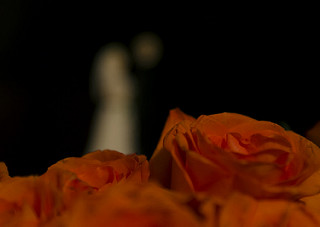

In [2]:
# Download a dataset of flower photos
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/" \
              "example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname="flower_photos",
                                   untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

# Rose photos
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[0]))

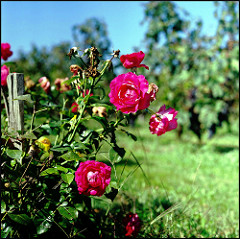

In [4]:
roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[1]))

In [5]:
# Load data with keras utility

# Loader parameters
batch_size = 32
img_height = 180
img_width = 180

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,   # Use 20% of data for validation
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Classes
class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


(32, 180, 180, 3)
(32,)


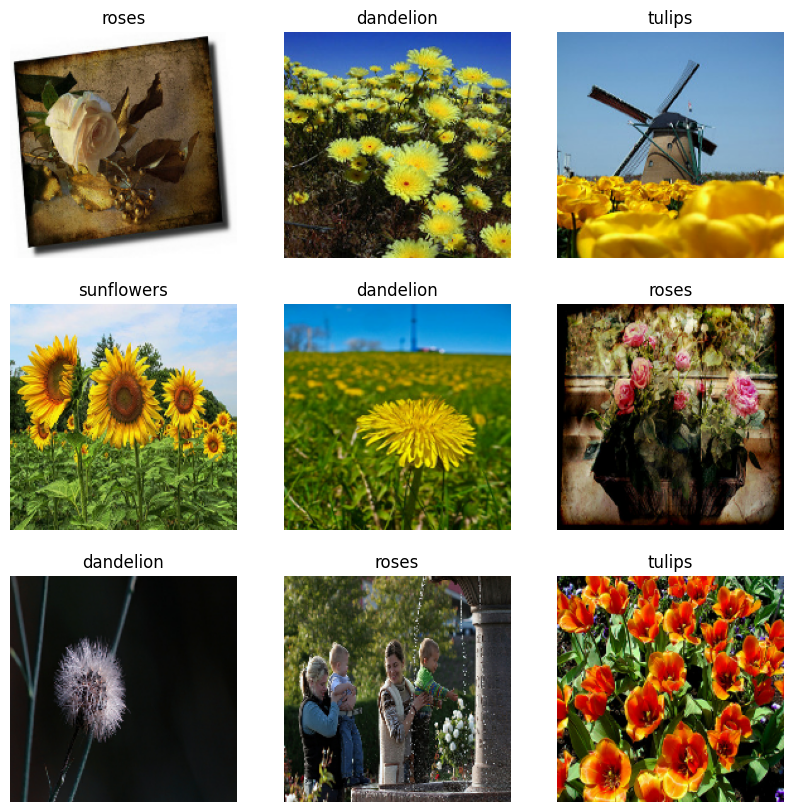

In [6]:
# Visualize the first 9 images
import matplotlib.pyplot as plt

# Plot the images in 3 columns 3 rows
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Batch shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [7]:
# Standardize data in [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# Scale data in [-1, 1]
# tf.keras.layers.Rescaling(1./127.5, offset=-1)

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) # Pixel values are in [0, 1]

0.0 0.96902645


In [8]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# Dataset.cache: keeps images in memory after they're loaded off disk
# during the first epoch
# Dataset.prefetch: overlaps preprocess and model execution while training
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Train a model
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255), # Standarization
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 147s 2s/step - loss: 1.2973 - accuracy: 0.4482 - val_loss: 1.1130 - val_accuracy: 0.5586
Epoch 2/3
92/92 [==============================] - 117s 1s/step - loss: 1.0179 - accuracy: 0.5943 - val_loss: 0.9623 - val_accuracy: 0.6144
Epoch 3/3
92/92 [==============================] - 116s 1s/step - loss: 0.8623 - accuracy: 0.6635 - val_loss: 0.8860 - val_accuracy: 0.6567


In [12]:
# Using tf.data for finer control

# Get a list of data files
list_ds = tf.data.Dataset.list_files(str(data_dir/"*/*"), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

# 5 data in the list
for f in list_ds.take(5):
    print(f.numpy())

# Class names
class_names = np.array(
    sorted([
        item.name for item in data_dir.glob("*")
        if item.name != "LICENSE.txt"
    ])
)
print(class_names)

# Split the dataset into training and validation sets
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

# Length of each dataset
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Create a dataset of (image, label) pairs
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

b'/root/.keras/datasets/flower_photos/daisy/6299910262_336309ffa5_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/7367491658_9eb4dc2384_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/3558517884_0c7ca8b862_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/16650892835_9228a3ef67_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/14375349004_68d893254a_n.jpg'
['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
2936
734
Image shape:  (180, 180, 3)
Label:  3


In [13]:
# Configure dataset for performance
def configure_for_performance(ds):
    ds = ds.cache() # Store data in RAM
    ds = ds.shuffle(buffer_size=1000) # Shuffle
    ds = ds.batch(batch_size) # Batch
    ds = ds.prefetch(buffer_size=AUTOTUNE) # Fetch the data while execution
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

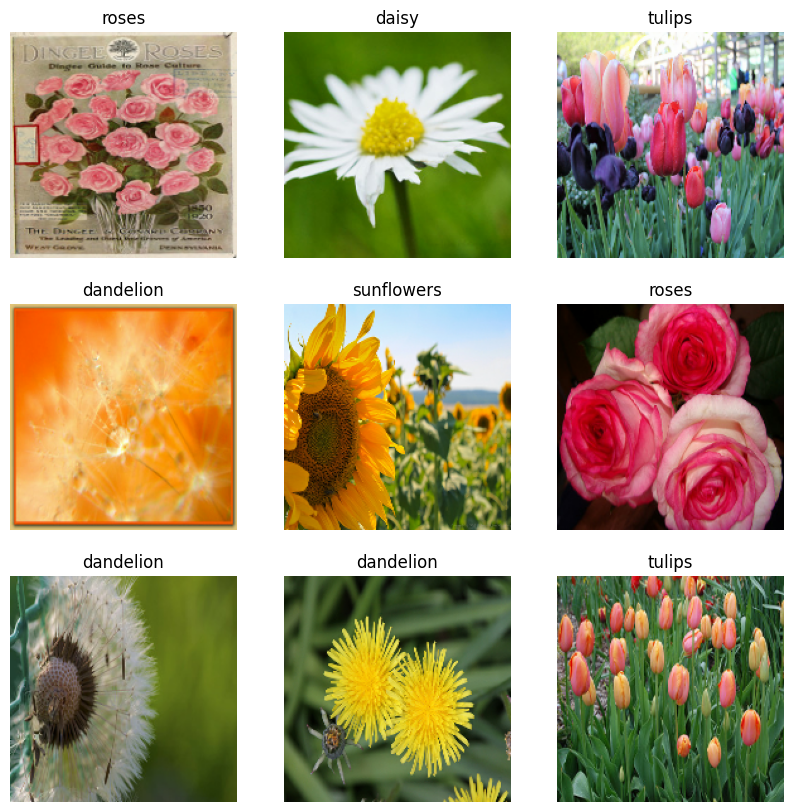

In [14]:
# Visualize the data
image_batch, label_batch = next(iter(train_ds))

# Plot images in 3 columns 3 rows
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [15]:
# Continue training the model
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 186s 2s/step - loss: 0.7583 - accuracy: 0.7101 - val_loss: 0.7598 - val_accuracy: 0.7003
Epoch 2/3
92/92 [==============================] - 154s 2s/step - loss: 0.5863 - accuracy: 0.7745 - val_loss: 0.6984 - val_accuracy: 0.7262
Epoch 3/3
92/92 [==============================] - 120s 1s/step - loss: 0.4325 - accuracy: 0.8423 - val_loss: 0.7034 - val_accuracy: 0.7289


5


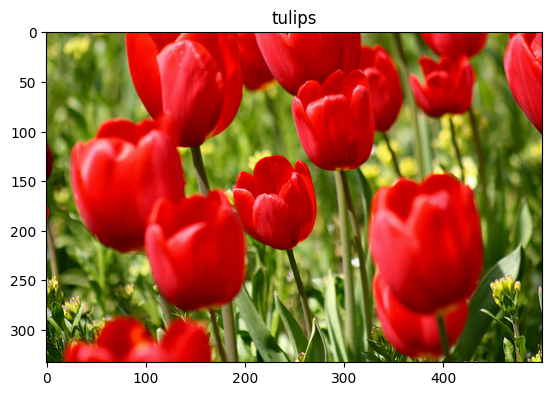

In [19]:
# Using TensorFlow datasets
(train_ds, val_ds, test_ds), metadata = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)

# The number of the classes
num_classes = metadata.features["label"].num_classes
print(num_classes)

# Retrieve an image from the dataset
image, label = next(iter(train_ds))
_ = plt.imshow(image)
get_label_name = metadata.features["label"].int2str
_ = plt.title(get_label_name(label))

# Training, validation and test dataset
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)